### 数据预处理

In [1]:
import csv
import pandas as pd
import numpy as np
import json

In [2]:
# data = pd.read_csv('data_new.csv')
# data = pd.read_csv('data_new_category.csv')
data = pd.read_csv('data_all_1008.csv')

In [17]:
target = [["有回应","无回应"], 
        ['积极','中性','消极'], 
        # ["专注（任务中）","走神（任务外）"], 
        # ["主导", "支持", "旁观", "冲突", "玩乐", "闲聊", "一人独立尝试一人摸鱼", "各自神游"],
        ["主导","支持","旁观","冲突","一人独立尝试一人摸鱼"]]

In [18]:
data.head()

,high face 0,high face 1,high face 2,high face 3,high face 4,high face 5,high face 6,high face 7,high face 8,high face 9,...,low pose 209,low pose 210,low pose 211,low pose 212,low pose 213,low pose 214,low pose 215,y1,y2,y3
0,0.359752,0.424275,-0.681706,0.433839,0.004776,0.001909,0.004776,0.001909,97.547158,48.476906,...,8.214190,2.834029,1.354602,7.016298,13.097574,37.208326,12.016522,0,0,2
1,0.374953,0.477638,-0.666732,0.429372,0.010201,0.002640,0.010201,0.002640,94.752225,45.264284,...,11.806845,2.437439,1.380893,8.850943,1.986816,14.843469,2.682850,0,0,2
2,0.374791,0.433773,-0.650851,0.302914,0.027013,0.007587,0.027013,0.007587,103.646422,66.342239,...,100.584290,264.340206,138.834556,277.803936,40.606839,39.674292,7.152803,0,0,0
3,0.425997,0.407457,-0.651442,0.335262,0.018433,0.004401,0.018433,0.004401,107.650662,116.364404,...,2.849081,1.480924,5.826735,0.277468,0.268455,3.716497,1.082155,0,0,0
4,0.283344,0.433831,-0.662919,0.331787,0.020136,0.011439,0.020136,0.011439,97.096686,181.962040,...,337.406190,2745.552274,351.139817,2397.996836,735.777116,293.425847,120.226725,0,0,1


In [6]:
X = data.drop(['y1','y2','y3'],axis=1)
y1 = data['y1']
# y2 = data['y2']
y3 = data['y2']
y4 = data['y3']
y = data[['y1','y2','y3']]

合并task4 的“冲突”，"玩乐"，"闲聊"，"各自神游"   
i.e. 3 4 5 7

In [55]:

# 将值为3、5和7的元素替换为4
data['y4'] = data['y4'].replace([3, 5, 7], 4) # 3457变为 4 代表新的类别
data['y4'] = data['y4'].replace([6],3)

y4 = data['y4']
y = data[['y1','y2','y3','y4']]

In [56]:
target[3] = ["主导", "支持", "旁观", "一人独立尝试一人摸鱼", "冲突等4类合并"]

In [7]:

null_values = X.isnull().any(axis=1)

# 获取空值行的索引
idx = null_values[null_values].index

idx

Index([], dtype='int64')

In [9]:
if len(idx) != 0:
    print(f"drop {len(idx)} rows with nan value")
    for i in idx:
        X = np.delete(X, i, axis=0)
        y1 = np.delete(y1, i, axis=0)
        # y2 = np.delete(y2, i, axis=0)
        y3 = np.delete(y3, i, axis=0)
        y4 = np.delete(y4, i, axis=0)
        y = np.delete(y, i, axis=0)
else:
    X = np.array(X)
    y1 = np.array(y1)
    # y2 = np.array(y2)
    y3 = np.array(y3)
    y4 = np.array(y4)
    y = np.array(y)

In [10]:
X_norm = np.apply_along_axis(lambda x: x / np.linalg.norm(x), axis=0, arr=X)


In [11]:
# check nan in X_norm
np.where(np.isnan(X_norm).any(axis=1)==True)

(array([], dtype=int64),)

In [12]:
print(f"Read in videos y:{len(y1)}")

Read in videos y:7025


维度

In [13]:
print(f"X:{len(X[0])}")

X:373


## Train 
注意下面的重复，每次只能跑一个情况

In [14]:
from sklearn.model_selection import train_test_split
# frame split
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=42)
print(f"Video num: X_train:{len(X_train)}, X_test:{len(X_test)}, y_train:{len(y_train)}, y_test:{len(y_test)}")

y1_train, y1_test = y_train[:,0], y_test[:,0]
# y2_train, y2_test = y_train[:,1], y_test[:,1]
y3_train, y3_test = y_train[:,1], y_test[:,1]
y4_train, y4_test = y_train[:,2], y_test[:,2]

Video num: X_train:5620, X_test:1405, y_train:5620, y_test:1405


查看数据分布

有回应:4785, 无回应:2240, 


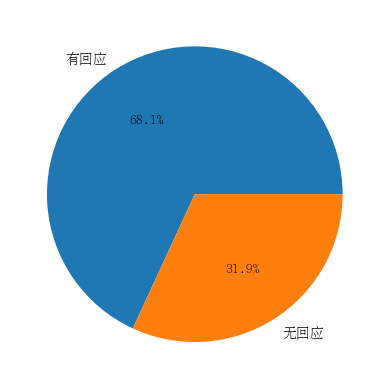

积极:2132, 中性:4185, 消极:708, 


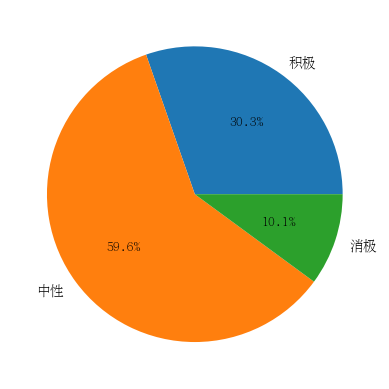

主导:1475, 支持:2311, 旁观:1835, 冲突:791, 一人独立尝试一人摸鱼:613, 


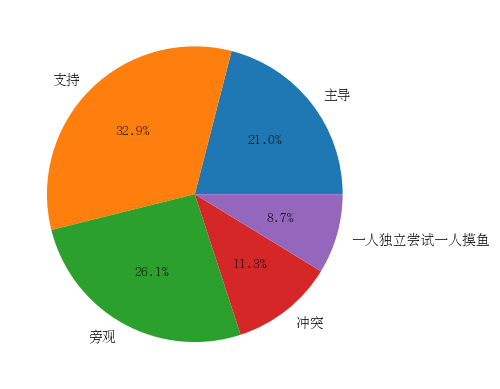

In [19]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties  # 步骤一

plt.rcParams["font.sans-serif"]=["AR PL UMing CN"] #设置字体
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题

def num_of_cls(y, target): 
    N = []
    for i in range(len(target)):
        print(target[i] + f":{len(y[y==i])}", end=", ")
        N.append(len(y[y==i]))
    print()
    return N

for i in range(len(target)):
    N = num_of_cls(y[:,i],target[i])
    # proportions = [ p/len(y) for p in N]
    plt.pie(N,labels=target[i],autopct='%1.1f%%')
    plt.show()


inversely proportional class weights

In [22]:
from sklearn.utils import class_weight
import numpy as np

# Calculate class weights
class_weights = [class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(i), y=i) for i in [y1,y3,y4]]


# Convert class weights to a dictionary for compatibility with some classifiers
class_weight_dict = [dict(enumerate(class_weights[i])) for i in range(3)]


over_sampling

In [23]:
from imblearn.over_sampling import RandomOverSampler, SMOTE

# RandomOverSampler
X1_resampled, y1_resampled = RandomOverSampler(random_state=42).fit_resample(X_train, y1_train)
# X2_resampled, y2_resampled = RandomOverSampler(random_state=42).fit_resample(X_train, y2_train)
X3_resampled, y3_resampled = RandomOverSampler(random_state=42).fit_resample(X_train, y3_train)
X4_resampled, y4_resampled = RandomOverSampler(random_state=42).fit_resample(X_train, y4_train)

# # SMOTE
# X1_resampled, y1_resampled = SMOTE().fit_resample(X_norm, y1)
# X2_resampled, y2_resampled = SMOTE().fit_resample(X_norm, y2)
# X3_resampled, y3_resampled = SMOTE().fit_resample(X_norm, y3)
# X4_resampled, y4_resampled = SMOTE().fit_resample(X_norm, y4)


POSE index！！！！！！！！！

In [24]:

lowface_idx = list(data.columns.get_indexer(data.filter(regex='^low face').columns))
highface_idx = list(data.columns.get_indexer(data.filter(regex='^high face').columns))
lowpose_idx = list(data.columns.get_indexer(data.filter(regex='^low pose').columns))
highpose_idx = list(data.columns.get_indexer(data.filter(regex='^high pose').columns))


In [25]:
face_idx =  highface_idx+lowface_idx
face_idx

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156]

In [26]:
pose_idx = highpose_idx+lowpose_idx
pose_idx

[46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 212,
 213,
 214,
 215,
 216,
 217,
 218,
 219,
 220,
 221,
 222,
 223,
 224,
 225,
 226,
 227,
 228,
 229,
 230,
 231,
 232,
 233,
 234,
 235,
 236,
 237,
 238,
 239,
 240,
 241,
 242,
 243,
 244,
 245,
 246,
 247,
 248,
 249,
 250,
 251,
 252,
 253,
 254,
 255,
 256,
 257,
 258,
 259,
 260,
 261,
 262,
 263,
 264,
 265,
 266,
 267,
 268,
 269,
 270,
 271,
 272,
 273,
 274,
 275,
 276,
 277,
 278,
 279,
 280,
 281,
 282,
 283,
 284,
 285,
 286,
 287,
 288,
 289,
 290,
 291,
 292,
 293,
 294,
 295,
 296,
 297,
 298,
 299,
 300,
 301,
 302,
 303,
 304,
 305,
 306,
 307,
 308,
 309,
 310,
 311,
 312,
 313,
 31

Cross-validation  
- 5 folds

In [27]:
from sklearn.model_selection import KFold, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score, recall_score, confusion_matrix
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV
from sklearn.metrics import classification_report

def crossVal(rfc, X, y):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    scoring = ['accuracy', 'f1_weighted', 'recall_weighted', 'precision_weighted']

    # 使用交叉验证器对模型进行评估
    scores = cross_validate(rfc, X, y, cv=kfold, scoring=scoring)

    # 输出交叉验证结果
    print('Accuracy:', scores['test_accuracy'].mean())
    print('F1 score:', scores['test_f1_weighted'].mean())
    print('Recall:', scores['test_recall_weighted'].mean())
    print('Precision:', scores['test_precision_weighted'].mean())

def GridSearch(estimator, param_grid, X_train, y_train, X_test, y_test, target, cv=5):
    # grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=cv)
    # grid_search = RandomizedSearchCV(estimator=estimator, param_grid=param_grid, cv=cv)
    # grid_search = HalvingGridSearchCV(estimator=estimator, param_distributions=param_grid, cv=cv)
    grid_search = HalvingRandomSearchCV(estimator=estimator,param_distributions=param_grid, cv=cv)


    grid_search.fit(X_train, y_train)

    # print(grid_search.best_params_, grid_search.best_score_)
    print("Best hyperparameters:", grid_search.best_params_)
    print("Best cross-validation score:", grid_search.best_score_)
    
    best_model = grid_search.best_estimator_
    test_score = best_model.score(X_test, y_test)
    y_predict = best_model.predict(X_test)
    print("Test score:", test_score)
    print("Report:")
    report = classification_report(y_test, y_predict, target_names=target, zero_division=0)
    # print(classification_report(y_test, y_predict, target_names=target, zero_division=0))
    confMat = confusion_matrix(y_test, y_predict) # how to upload??
    return best_model, report, grid_search.best_params_

In [28]:
import csv
def parse_report( method, params, report, csv_dir):
    """
    method: [task, classifer, hyperparameters]
    """
    # Parse the classification report
    print(report)
    type(report)
    lines = report.split('\n')
    data = lines[-3:]
    values = [line.split() for line in data]

    # Extract the desired values
    precision = float(values[0][2])
    recall = float(values[0][3])
    f1_score = float(values[0][4])

    # Extract the desired values
    Wprecision = float(values[1][2])
    Wrecall = float(values[1][3])
    Wf1_score = float(values[1][4])

    # Print the extracted values
    print(f"Precision: {precision}, Recall: {recall}, F1-score: {f1_score}, WPrecision: {Wprecision}, WRecall: {Wrecall}, WF1-score: {Wf1_score}")
    with open(csv_dir,'a',newline='') as file:
        writer = csv.writer(file)
        writer.writerow(method)
        writer.writerow(params.keys())
        writer.writerow(params.values())
        writer.writerow([precision,recall,f1_score,Wprecision,Wrecall,Wf1_score])
        writer.writerow([])


### Random Forest

In [30]:

from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

# 使用随机森林预测一个frame
rfc = RandomForestClassifier(n_estimators=100, max_depth=10)
rfc.fit(X_train, y_train)
y_predict = rfc.predict(X_test)

for i in range(len(target)):
    print(f"----------------------Task {i}----------------------")
    print(classification_report(y_test[:,i], y_predict[:,i], target_names=target[i],zero_division=0))
    num_of_cls(y_predict[:,i],target[i])


----------------------Task 0----------------------
              precision    recall  f1-score   support

         有回应       0.73      0.96      0.83       939
         无回应       0.79      0.30      0.43       466

    accuracy                           0.74      1405
   macro avg       0.76      0.63      0.63      1405
weighted avg       0.75      0.74      0.70      1405

有回应:1231, 无回应:174, 
----------------------Task 1----------------------
              precision    recall  f1-score   support

          积极       0.78      0.16      0.26       392
          中性       0.63      0.98      0.77       853
          消极       0.00      0.00      0.00       160

    accuracy                           0.64      1405
   macro avg       0.47      0.38      0.34      1405
weighted avg       0.60      0.64      0.54      1405

积极:80, 中性:1325, 消极:0, 
----------------------Task 2----------------------
              precision    recall  f1-score   support

          主导       0.51      0.17      0.

In [31]:
csv_dir = "result_all_full_1008.csv"

#### task 1

In [61]:
# GridSearch

rfc = RandomForestClassifier()

param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight':[class_weight_dict[0]] 
}
feat_sel = {
    "F_Face":face_idx, 
    "HF_HighFace":highface_idx, 
    "LF_LowFace":highface_idx, 
    "P_Pose":pose_idx,
    "HP_HighPose":highpose_idx,
    "LP_LowPose":lowpose_idx
    }


for k in feat_sel.keys():
    
    RandomForest,report,param = GridSearch(estimator=rfc, 
                            param_grid=param_grid, 
                            X_train=X_train[:,feat_sel[k]], y_train=y1_train, 
                            X_test=X_test[:,feat_sel[k]], y_test=y1_test,
                            target=target[0], cv=5)
                            
    parse_report(method=["Task1","RandomForest @" + k], params = param, report=report, csv_dir=csv_dir)
    
# RandomForest,report,param = GridSearch(estimator=rfc, 
#                             param_grid=param_grid, 
#                             X_train=X_train, y_train=y1_train, 
#                             X_test=X_test, y_test=y1_test,
#                             target=target[0], cv=5)
                            
# parse_report(method=["task1","RandomForest"], params = param, report=report, csv_dir=csv_dir)



/home/ansonlo/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 144 is smaller than n_iter=281. Running 144 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best hyperparameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 30, 'class_weight': {0: 0.7340647857889238, 1: 1.5680803571428572}}
Best cross-validation score: 0.7055555555555555
Test score: 0.7088967971530249
Report:
              precision    recall  f1-score   support

         有回应       0.71      0.96      0.82       939
         无回应       0.71      0.20      0.32       466

    accuracy                           0.71      1405
   macro avg       0.71      0.58      0.57      1405
weighted avg       0.71      0.71      0.65      1405

Precision: 0.71, Recall: 0.58, F1-score: 0.57, WPrecision: 0.71, WRecall: 0.71, WF1-score: 0.65


/home/ansonlo/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 144 is smaller than n_iter=281. Running 144 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best hyperparameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 30, 'class_weight': {0: 0.7340647857889238, 1: 1.5680803571428572}}
Best cross-validation score: 0.6944444444444444
Test score: 0.7124555160142348
Report:
              precision    recall  f1-score   support

         有回应       0.71      0.95      0.82       939
         无回应       0.71      0.23      0.34       466

    accuracy                           0.71      1405
   macro avg       0.71      0.59      0.58      1405
weighted avg       0.71      0.71      0.66      1405

Precision: 0.71, Recall: 0.59, F1-score: 0.58, WPrecision: 0.71, WRecall: 0.71, WF1-score: 0.66


/home/ansonlo/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 144 is smaller than n_iter=281. Running 144 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best hyperparameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30, 'class_weight': {0: 0.7340647857889238, 1: 1.5680803571428572}}
Best cross-validation score: 0.7012345679012346
Test score: 0.702491103202847
Report:
              precision    recall  f1-score   support

         有回应       0.70      0.96      0.81       939
         无回应       0.69      0.19      0.29       466

    accuracy                           0.70      1405
   macro avg       0.70      0.57      0.55      1405
weighted avg       0.70      0.70      0.64      1405

Precision: 0.7, Recall: 0.57, F1-score: 0.55, WPrecision: 0.7, WRecall: 0.7, WF1-score: 0.64


/home/ansonlo/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 144 is smaller than n_iter=281. Running 144 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best hyperparameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 10, 'class_weight': {0: 0.7340647857889238, 1: 1.5680803571428572}}
Best cross-validation score: 0.6993827160493827
Test score: 0.7409252669039146
Report:
              precision    recall  f1-score   support

         有回应       0.77      0.88      0.82       939
         无回应       0.66      0.46      0.54       466

    accuracy                           0.74      1405
   macro avg       0.71      0.67      0.68      1405
weighted avg       0.73      0.74      0.73      1405

Precision: 0.71, Recall: 0.67, F1-score: 0.68, WPrecision: 0.73, WRecall: 0.74, WF1-score: 0.73


/home/ansonlo/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 144 is smaller than n_iter=281. Running 144 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best hyperparameters: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 30, 'class_weight': {0: 0.7340647857889238, 1: 1.5680803571428572}}
Best cross-validation score: 0.6901234567901234
Test score: 0.695373665480427
Report:
              precision    recall  f1-score   support

         有回应       0.72      0.88      0.79       939
         无回应       0.57      0.33      0.42       466

    accuracy                           0.70      1405
   macro avg       0.65      0.60      0.60      1405
weighted avg       0.67      0.70      0.67      1405

Precision: 0.65, Recall: 0.6, F1-score: 0.6, WPrecision: 0.67, WRecall: 0.7, WF1-score: 0.67


/home/ansonlo/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 144 is smaller than n_iter=281. Running 144 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best hyperparameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 20, 'class_weight': {0: 0.7340647857889238, 1: 1.5680803571428572}}
Best cross-validation score: 0.7277777777777777
Test score: 0.7366548042704626
Report:
              precision    recall  f1-score   support

         有回应       0.74      0.93      0.83       939
         无回应       0.72      0.34      0.46       466

    accuracy                           0.74      1405
   macro avg       0.73      0.64      0.64      1405
weighted avg       0.73      0.74      0.71      1405

Precision: 0.73, Recall: 0.64, F1-score: 0.64, WPrecision: 0.73, WRecall: 0.74, WF1-score: 0.71


#### Task 2

In [26]:
# GridSearch
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight':[class_weight_dict[1]] 
}
rfc = RandomForestClassifier()
RandomForest,report,param = GridSearch(estimator=rfc, param_grid=param_grid, 
                            X_train=X_train, y_train=y2_train, 
                            X_test=X_test, y_test=y2_test,
                            target=target[1], cv=5)

parse_report(method=["task2","RandomForest"], params = param, report=report, csv_dir=csv_dir)                            

Best hyperparameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': None, 'class_weight': {0: 1.0839019459186252, 1: 0.5937153931339978, 2: 2.543890865954923}}
Best cross-validation score: 0.5931551482754231
Test score: 0.6235431235431236
Report:
              precision    recall  f1-score   support

          积极       0.68      0.31      0.42       250
          中性       0.62      0.93      0.74       490
          消极       0.00      0.00      0.00       118

    accuracy                           0.62       858
   macro avg       0.43      0.41      0.39       858
weighted avg       0.55      0.62      0.55       858

Precision: 0.43, Recall: 0.41, F1-score: 0.39, WPrecision: 0.55, WRecall: 0.62, WF1-score: 0.55


#### Task 3

In [62]:
# GridSearch
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight':[class_weight_dict[1]] 
}
rfc = RandomForestClassifier()
for k in feat_sel.keys():
    
    RandomForest,report,param = GridSearch(estimator=rfc, 
                            param_grid=param_grid, 
                            X_train=X_train[:,feat_sel[k]], y_train=y3_train, 
                            X_test=X_test[:,feat_sel[k]], y_test=y3_test,
                            target=target[1], cv=5)
                            
    parse_report(method=["Task3","RandomForest @" + k], params = param, report=report, csv_dir=csv_dir)

# RandomForest,report,param = GridSearch(estimator=rfc, param_grid=param_grid, 
#                             X_train=X_train, y_train=y3_train, 
#                             X_test=X_test, y_test=y3_test,
#                             target=target[1], cv=5)
                            
# parse_report(method=["task3","RandomForest"], params = param, report=report, csv_dir=csv_dir)  

/home/ansonlo/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 144 is smaller than n_iter=187. Running 144 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best hyperparameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 30, 'class_weight': {0: 1.0983427141963726, 1: 0.5595380326563122, 2: 3.3074387947269304}}
Best cross-validation score: 0.6209876543209877
Test score: 0.6334519572953736
Report:
              precision    recall  f1-score   support

          积极       0.54      0.30      0.39       392
          中性       0.65      0.90      0.76       853
          消极       0.00      0.00      0.00       160

    accuracy                           0.63      1405
   macro avg       0.40      0.40      0.38      1405
weighted avg       0.55      0.63      0.57      1405

Precision: 0.4, Recall: 0.4, F1-score: 0.38, WPrecision: 0.55, WRecall: 0.63, WF1-score: 0.57


/home/ansonlo/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 144 is smaller than n_iter=187. Running 144 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best hyperparameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20, 'class_weight': {0: 1.0983427141963726, 1: 0.5595380326563122, 2: 3.3074387947269304}}
Best cross-validation score: 0.5839506172839507
Test score: 0.599288256227758
Report:
              precision    recall  f1-score   support

          积极       0.41      0.09      0.15       392
          中性       0.61      0.95      0.74       853
          消极       0.00      0.00      0.00       160

    accuracy                           0.60      1405
   macro avg       0.34      0.35      0.30      1405
weighted avg       0.49      0.60      0.49      1405

Precision: 0.34, Recall: 0.35, F1-score: 0.3, WPrecision: 0.49, WRecall: 0.6, WF1-score: 0.49


/home/ansonlo/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 144 is smaller than n_iter=187. Running 144 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best hyperparameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20, 'class_weight': {0: 1.0983427141963726, 1: 0.5595380326563122, 2: 3.3074387947269304}}
Best cross-validation score: 0.5921810699588477
Test score: 0.6071174377224199
Report:
              precision    recall  f1-score   support

          积极       0.47      0.10      0.17       392
          中性       0.62      0.95      0.75       853
          消极       0.00      0.00      0.00       160

    accuracy                           0.61      1405
   macro avg       0.36      0.35      0.31      1405
weighted avg       0.51      0.61      0.50      1405

Precision: 0.36, Recall: 0.35, F1-score: 0.31, WPrecision: 0.51, WRecall: 0.61, WF1-score: 0.5


/home/ansonlo/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 144 is smaller than n_iter=187. Running 144 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best hyperparameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30, 'class_weight': {0: 1.0983427141963726, 1: 0.5595380326563122, 2: 3.3074387947269304}}
Best cross-validation score: 0.5954732510288065
Test score: 0.6249110320284698
Report:
              precision    recall  f1-score   support

          积极       0.60      0.14      0.23       392
          中性       0.63      0.96      0.76       853
          消极       1.00      0.01      0.01       160

    accuracy                           0.62      1405
   macro avg       0.74      0.37      0.33      1405
weighted avg       0.66      0.62      0.53      1405

Precision: 0.74, Recall: 0.37, F1-score: 0.33, WPrecision: 0.66, WRecall: 0.62, WF1-score: 0.53


/home/ansonlo/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 144 is smaller than n_iter=187. Running 144 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best hyperparameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None, 'class_weight': {0: 1.0983427141963726, 1: 0.5595380326563122, 2: 3.3074387947269304}}
Best cross-validation score: 0.588477366255144
Test score: 0.604270462633452
Report:
              precision    recall  f1-score   support

          积极       0.42      0.08      0.13       392
          中性       0.61      0.96      0.75       853
          消极       1.00      0.01      0.01       160

    accuracy                           0.60      1405
   macro avg       0.68      0.35      0.30      1405
weighted avg       0.60      0.60      0.49      1405

Precision: 0.68, Recall: 0.35, F1-score: 0.3, WPrecision: 0.6, WRecall: 0.6, WF1-score: 0.49


/home/ansonlo/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 144 is smaller than n_iter=187. Running 144 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best hyperparameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None, 'class_weight': {0: 1.0983427141963726, 1: 0.5595380326563122, 2: 3.3074387947269304}}
Best cross-validation score: 0.6193415637860082
Test score: 0.6384341637010676
Report:
              precision    recall  f1-score   support

          积极       0.63      0.21      0.32       392
          中性       0.64      0.95      0.76       853
          消极       1.00      0.01      0.02       160

    accuracy                           0.64      1405
   macro avg       0.76      0.39      0.37      1405
weighted avg       0.68      0.64      0.56      1405

Precision: 0.76, Recall: 0.39, F1-score: 0.37, WPrecision: 0.68, WRecall: 0.64, WF1-score: 0.56


#### Task 4

In [63]:
# GridSearch lowpose!
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight':[class_weight_dict[2]] 
}
rfc = RandomForestClassifier()
for k in feat_sel.keys():
    
    RandomForest,report,param = GridSearch(estimator=rfc, 
                            param_grid=param_grid, 
                            X_train=X_train[:,feat_sel[k]], y_train=y4_train, 
                            X_test=X_test[:,feat_sel[k]], y_test=y4_test,
                            target=target[2], cv=5)
                            
    parse_report(method=["Task4","RandomForest @" + k], params = param, report=report, csv_dir=csv_dir)

# RandomForest,report,param = GridSearch(estimator=rfc, param_grid=param_grid, 
#                             X_train=X_train, y_train=y4_train, 
#                             X_test=X_test, y_test=y4_test,
#                             target=target[2], cv=5)
# parse_report(method=["task4","RandomForest"], params = param, report=report, csv_dir=csv_dir)  


Best hyperparameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 30, 'class_weight': {0: 0.9525423728813559, 1: 0.6079619212462137, 2: 0.7656675749318801, 3: 1.7762326169405815, 4: 2.292006525285481}}
Best cross-validation score: 0.42148148148148146
Test score: 0.44483985765124556
Report:
              precision    recall  f1-score   support

          主导       0.47      0.27      0.34       301
          支持       0.44      0.67      0.53       440
          旁观       0.45      0.37      0.41       367
          冲突       0.33      0.31      0.32       167
  一人独立尝试一人摸鱼       0.57      0.48      0.52       130

    accuracy                           0.44      1405
   macro avg       0.45      0.42      0.42      1405
weighted avg       0.45      0.44      0.43      1405

Precision: 0.45, Recall: 0.42, F1-score: 0.42, WPrecision: 0.45, WRecall: 0.44, WF1-score: 0.43
Best hyperparameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf'

### DT

In [37]:
from sklearn.tree import DecisionTreeClassifier
# 建立决策树分类器
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
for i in range(len(target)):
    print(f"----------------------Task {i}----------------------")
    print(classification_report(y_test[:,i], y_predict[:,i], target_names=target[i],zero_division=0))
    num_of_cls(y_predict[:,i],target[i])

----------------------Task 0----------------------
              precision    recall  f1-score   support

         有回应       0.74      0.74      0.74       939
         无回应       0.48      0.48      0.48       466

    accuracy                           0.66      1405
   macro avg       0.61      0.61      0.61      1405
weighted avg       0.66      0.66      0.66      1405

有回应:939, 无回应:466, 
----------------------Task 1----------------------
              precision    recall  f1-score   support

          积极       0.36      0.42      0.39       392
          中性       0.65      0.60      0.62       853
          消极       0.21      0.20      0.21       160

    accuracy                           0.51      1405
   macro avg       0.41      0.41      0.41      1405
weighted avg       0.52      0.51      0.51      1405

积极:454, 中性:799, 消极:152, 
----------------------Task 2----------------------
              precision    recall  f1-score   support

          主导       0.33      0.33      0

#### task 1

In [38]:
# GridSearch
clf = DecisionTreeClassifier()

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30, 40, 50, 70, 90, 120, 150],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight':[class_weight_dict[0]] 
}
for k in feat_sel.keys():
    
    DT,report,param = GridSearch(estimator=clf, 
                            param_grid=param_grid, 
                            X_train=X_train[:,feat_sel[k]], y_train=y1_train, 
                            X_test=X_test[:,feat_sel[k]], y_test=y1_test,
                            target=target[0], cv=5)
                            
    parse_report(method=["Task1","DT @" + k], params = param, report=report, csv_dir=csv_dir)

# DT,report,param = GridSearch(estimator=clf, 
#                 param_grid=param_grid, 
#                 X_train=X_train, y_train=y1_train, 
#                 X_test=X_test, y_test=y1_test,
#                 target=target[0], cv=5)
# parse_report(method=["task1","DT"], params = param, report=report, csv_dir=csv_dir)  


Best hyperparameters: {'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 120, 'criterion': 'entropy', 'class_weight': {0: 0.7340647857889238, 1: 1.5680803571428572}}
Best cross-validation score: 0.6502057613168725
Test score: 0.6334519572953736
Report:
              precision    recall  f1-score   support

         有回应       0.72      0.74      0.73       939
         无回应       0.44      0.42      0.43       466

    accuracy                           0.63      1405
   macro avg       0.58      0.58      0.58      1405
weighted avg       0.63      0.63      0.63      1405

Precision: 0.58, Recall: 0.58, F1-score: 0.58, WPrecision: 0.63, WRecall: 0.63, WF1-score: 0.63


#### task 2

In [31]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30, 40, 50, 70, 90, 120, 150],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight':[class_weight_dict[1]] 
}
clf = DecisionTreeClassifier()
DT,report,param = GridSearch(estimator=clf, 
                param_grid=param_grid, 
                X_train=X_train, y_train=y2_train, 
                X_test=X_test, y_test=y2_test,
                target=target[1], cv=5)

parse_report(method=["task2","DT"], params = param, report=report, csv_dir=csv_dir)  

Best hyperparameters: {'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 30, 'criterion': 'gini', 'class_weight': {0: 1.0839019459186252, 1: 0.5937153931339978, 2: 2.543890865954923}}
Best cross-validation score: 0.48020533706673457
Test score: 0.5011655011655012
Report:
              precision    recall  f1-score   support

          积极       0.42      0.42      0.42       250
          中性       0.62      0.61      0.61       490
          消极       0.21      0.22      0.22       118

    accuracy                           0.50       858
   macro avg       0.42      0.42      0.42       858
weighted avg       0.50      0.50      0.50       858

Precision: 0.42, Recall: 0.42, F1-score: 0.42, WPrecision: 0.5, WRecall: 0.5, WF1-score: 0.5


#### task 3

In [39]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30, 40, 50, 70, 90, 120, 150],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight':[class_weight_dict[1]] 
}
clf = DecisionTreeClassifier()

for k in feat_sel.keys():
    
    DT,report,param = GridSearch(estimator=clf, 
                            param_grid=param_grid, 
                            X_train=X_train[:,feat_sel[k]], y_train=y3_train, 
                            X_test=X_test[:,feat_sel[k]], y_test=y3_test,
                            target=target[1], cv=5)
                            
    parse_report(method=["Task3","DT @" + k], params = param, report=report, csv_dir=csv_dir)

# DT,report,param = GridSearch(estimator=clf, 
#                 param_grid=param_grid, 
#                 X_train=X_train, y_train=y3_train, 
#                 X_test=X_test, y_test=y3_test,
#                 target=target[1], cv=5)


# parse_report(method=["task3","DT"], params = param, report=report, csv_dir=csv_dir)  

Best hyperparameters: {'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 50, 'criterion': 'entropy', 'class_weight': {0: 1.0983427141963726, 1: 0.5595380326563122, 2: 3.3074387947269304}}
Best cross-validation score: 0.4897119341563786
Test score: 0.5174377224199288
Report:
              precision    recall  f1-score   support

          积极       0.38      0.44      0.40       392
          中性       0.67      0.62      0.64       853
          消极       0.19      0.19      0.19       160

    accuracy                           0.52      1405
   macro avg       0.41      0.42      0.41      1405
weighted avg       0.53      0.52      0.52      1405

Precision: 0.41, Recall: 0.42, F1-score: 0.41, WPrecision: 0.53, WRecall: 0.52, WF1-score: 0.52


#### task 4

In [40]:
clf = DecisionTreeClassifier()
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30, 40, 50, 70, 90, 120, 150],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight':[class_weight_dict[2]] 
}

for k in feat_sel.keys():
    
    DT,report,param = GridSearch(estimator=clf, 
                            param_grid=param_grid, 
                            X_train=X_train[:,feat_sel[k]], y_train=y4_train, 
                            X_test=X_test[:,feat_sel[k]], y_test=y4_test,
                            target=target[2], cv=5)
                            
    parse_report(method=["Task4","DT @" + k], params = param, report=report, csv_dir=csv_dir)

# DT,report,param = GridSearch(estimator=clf, 
#                 param_grid=param_grid, 
#                 X_train=X_train[:,face_idx], y_train=y4_train, 
#                 X_test=X_test[:,face_idx], y_test=y4_test,
#                 target=target[2], cv=5)
# # pose
# # [:,pose_idx]
# parse_report(method=["task4","DT"], params = param, report=report, csv_dir=csv_dir)  


Best hyperparameters: {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 90, 'criterion': 'entropy', 'class_weight': {0: 0.9525423728813559, 1: 0.6079619212462137, 2: 0.7656675749318801, 3: 1.7762326169405815, 4: 2.292006525285481}}
Best cross-validation score: 0.32271604938271603
Test score: 0.3074733096085409
Report:
              precision    recall  f1-score   support

          主导       0.27      0.27      0.27       301
          支持       0.37      0.36      0.36       440
          旁观       0.31      0.33      0.32       367
          冲突       0.17      0.17      0.17       167
  一人独立尝试一人摸鱼       0.34      0.35      0.35       130

    accuracy                           0.31      1405
   macro avg       0.29      0.29      0.29      1405
weighted avg       0.31      0.31      0.31      1405

Precision: 0.29, Recall: 0.29, F1-score: 0.29, WPrecision: 0.31, WRecall: 0.31, WF1-score: 0.31


### KNN

In [41]:
from sklearn.neighbors import KNeighborsClassifier

# 建立KNN分类器
clf = KNeighborsClassifier(n_neighbors=3)

#### task 1

In [ ]:
# GridSearch
clf = KNeighborsClassifier()

param_grid = {
    'n_neighbors': list(range(1, 25)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
    'leaf_size': list(range(1, 51))
}
KNN,report,param = GridSearch(estimator=clf, param_grid=param_grid, 
                            X_train=X_train, y_train=y1_train, 
                            X_test=X_test, y_test=y1_test,
                            target=target[0], cv=5)
parse_report(method=["task1","KNN"], params = param, report=report, csv_dir=csv_dir)  


upsample!

In [44]:
# GridSearch
clf = KNeighborsClassifier()

param_grid = {
    'n_neighbors': list(range(1, 25)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
    'leaf_size': list(range(1, 51))
}

for k in feat_sel.keys():
    
    KNN,report,param = GridSearch(estimator=clf, 
                            param_grid=param_grid, 
                            X_train=X1_resampled[:,feat_sel[k]], y_train=y1_resampled, 
                            X_test=X_test[:,feat_sel[k]], y_test=y1_test,
                            target=target[0], cv=5)
                            
    parse_report(method=["Task1 upsample","KNN @" + k], params = param, report=report, csv_dir=csv_dir)

# KNN,report,param = GridSearch(estimator=clf, param_grid=param_grid, 
#                             # X_train=X_train, y_train=y1_train, 
#                             X_train=X1_resampled, y_train=y1_resampled,
#                             X_test=X_test, y_test=y1_test,
#                             target=target[0], cv=5)
# parse_report(method=["task1 upsample","KNN"], params = param, report=report, csv_dir=csv_dir)  

/home/ansonlo/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ansonlo/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/ansonlo/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/ansonlo/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/base.py", line 668, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/home/ansonlo/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 234, in predict
    neigh_ind = self.kneighbors(X, return_distance=False)
  File "/ho

Best hyperparameters: {'weights': 'distance', 'p': 1, 'n_neighbors': 14, 'leaf_size': 2}
Best cross-validation score: 0.7908331320220553
Test score: 0.6896797153024911
Report:
              precision    recall  f1-score   support

         有回应       0.77      0.76      0.77       939
         无回应       0.53      0.55      0.54       466

    accuracy                           0.69      1405
   macro avg       0.65      0.65      0.65      1405
weighted avg       0.69      0.69      0.69      1405

Precision: 0.65, Recall: 0.65, F1-score: 0.65, WPrecision: 0.69, WRecall: 0.69, WF1-score: 0.69


#### task 2

In [36]:
# GridSearch
param_grid = {
    'n_neighbors': list(range(1, 29)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
    'leaf_size': list(range(1, 51))
}
clf = KNeighborsClassifier()
KNN,report,param = GridSearch(estimator=clf, param_grid=param_grid, 
                            X_train=X_train, y_train=y2_train, 
                            X_test=X_test, y_test=y2_test,
                            target=target[1], cv=6)
parse_report(method=["task2","KNN"], params = param, report=report, csv_dir=csv_dir)                             

Best hyperparameters: {'weights': 'distance', 'p': 1, 'n_neighbors': 26, 'leaf_size': 16}
Best cross-validation score: 0.5807828829211036
Test score: 0.6060606060606061
Report:
              precision    recall  f1-score   support

          积极       0.64      0.24      0.35       250
          中性       0.60      0.94      0.73       490
          消极       0.00      0.00      0.00       118

    accuracy                           0.61       858
   macro avg       0.41      0.39      0.36       858
weighted avg       0.53      0.61      0.52       858

Precision: 0.41, Recall: 0.39, F1-score: 0.36, WPrecision: 0.53, WRecall: 0.61, WF1-score: 0.52


#### task 3

In [45]:
param_grid = {
    'n_neighbors': list(range(1, 29)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
    'leaf_size': list(range(1, 51))
}
clf = KNeighborsClassifier()
KNN,report,param = GridSearch(estimator=clf, param_grid=param_grid, 
                            X_train=X_train, y_train=y3_train, 
                            X_test=X_test, y_test=y3_test,
                            target=target[1], cv=10)

parse_report(method=["task3","KNN"], params = param, report=report, csv_dir=csv_dir)  

Best hyperparameters: {'weights': 'distance', 'p': 1, 'n_neighbors': 15, 'leaf_size': 48}
Best cross-validation score: 0.6228395061728395
Test score: 0.6491103202846975
Report:
              precision    recall  f1-score   support

          积极       0.63      0.27      0.38       392
          中性       0.65      0.94      0.77       853
          消极       0.38      0.02      0.04       160

    accuracy                           0.65      1405
   macro avg       0.55      0.41      0.40      1405
weighted avg       0.62      0.65      0.58      1405

Precision: 0.55, Recall: 0.41, F1-score: 0.4, WPrecision: 0.62, WRecall: 0.65, WF1-score: 0.58


upsample

In [46]:
param_grid = {
    'n_neighbors': list(range(1, 29)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
    'leaf_size': list(range(1, 51))
}
clf = KNeighborsClassifier()


for k in feat_sel.keys():
    
    KNN,report,param = GridSearch(estimator=clf, 
                            param_grid=param_grid, 
                            X_train=X3_resampled[:,feat_sel[k]], y_train=y3_resampled, 
                            X_test=X_test[:,feat_sel[k]], y_test=y3_test,
                            target=target[1], cv=5)
                            
    parse_report(method=["Task3 upsample","KNN @" + k], params = param, report=report, csv_dir=csv_dir)
# KNN,report,param = GridSearch(estimator=clf, param_grid=param_grid, 
#                             X_train=X3_resampled, y_train=y3_resampled, 
#                             X_test=X_test, y_test=y3_test,
#                             target=target[1], cv=10)

# parse_report(method=["task3 upsample","KNN"], params = param, report=report, csv_dir=csv_dir)  

Best hyperparameters: {'weights': 'distance', 'p': 1, 'n_neighbors': 22, 'leaf_size': 34}
Best cross-validation score: 0.7041105595859319
Test score: 0.4797153024911032
Report:
              precision    recall  f1-score   support

          积极       0.45      0.44      0.45       392
          中性       0.73      0.49      0.59       853
          消极       0.18      0.51      0.27       160

    accuracy                           0.48      1405
   macro avg       0.45      0.48      0.43      1405
weighted avg       0.59      0.48      0.51      1405

Precision: 0.45, Recall: 0.48, F1-score: 0.43, WPrecision: 0.59, WRecall: 0.48, WF1-score: 0.51


#### task 4

In [50]:
#pose
param_grid = {
    'n_neighbors': list(range(1, 29)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
    'leaf_size': list(range(1, 51))
}
clf = KNeighborsClassifier()
KNN,report,param = GridSearch(estimator=clf, param_grid=param_grid, 
                            # X_train=X_train[:,face_idx], y_train=y4_train, 
                            # X_test=X_test[:,face_idx], y_test=y4_test,
                            X_train=X_train, y_train=y4_train, 
                            X_test=X_test, y_test=y4_test,
                            target=target[2], cv=5)
parse_report(method=["task4","KNN"], params = param, report=report, csv_dir=csv_dir)  




Best hyperparameters: {'weights': 'distance', 'p': 2, 'n_neighbors': 11, 'leaf_size': 49}
Best cross-validation score: 0.35283950617283955
Test score: 0.3480427046263345
Report:
              precision    recall  f1-score   support

          主导       0.28      0.40      0.33       301
          支持       0.40      0.40      0.40       440
          旁观       0.33      0.43      0.37       367
          冲突       0.30      0.05      0.09       167
  一人独立尝试一人摸鱼       0.61      0.24      0.34       130

    accuracy                           0.35      1405
   macro avg       0.38      0.30      0.31      1405
weighted avg       0.37      0.35      0.34      1405

Precision: 0.38, Recall: 0.3, F1-score: 0.31, WPrecision: 0.37, WRecall: 0.35, WF1-score: 0.34


upsample

In [51]:
#pose
param_grid = {
    'n_neighbors': list(range(1, 29)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
    'leaf_size': list(range(1, 51))
}
clf = KNeighborsClassifier()


for k in feat_sel.keys():
    
    KNN,report,param = GridSearch(estimator=clf, 
                            param_grid=param_grid, 
                            X_train=X4_resampled[:,feat_sel[k]], y_train=y4_resampled, 
                            X_test=X_test[:,feat_sel[k]], y_test=y4_test,
                            target=target[2], cv=5)
                            
    parse_report(method=["Task4 upsample","KNN @" + k], params = param, report=report, csv_dir=csv_dir)

# KNN,report,param = GridSearch(estimator=clf, param_grid=param_grid, 
#                             X_train=X4_resampled, y_train=y4_resampled,  
#                             X_test=X_test, y_test=y4_test,
#                             target=target[2], cv=5)
# parse_report(method=["task4 upsample","KNN"], params = param, report=report, csv_dir=csv_dir)  




Best hyperparameters: {'weights': 'distance', 'p': 1, 'n_neighbors': 3, 'leaf_size': 31}
Best cross-validation score: 0.6
Test score: 0.34519572953736655
Report:
              precision    recall  f1-score   support

          主导       0.31      0.45      0.36       301
          支持       0.43      0.22      0.29       440
          旁观       0.33      0.40      0.36       367
          冲突       0.27      0.24      0.25       167
  一人独立尝试一人摸鱼       0.49      0.52      0.50       130

    accuracy                           0.35      1405
   macro avg       0.36      0.36      0.35      1405
weighted avg       0.36      0.35      0.34      1405

Precision: 0.36, Recall: 0.36, F1-score: 0.35, WPrecision: 0.36, WRecall: 0.35, WF1-score: 0.34


### SVM
结果很差 看warning原因应该是有一些结果直接没有分类  
看看是否需要调参数或者直接去掉 

In [52]:
from sklearn.svm import SVC
clf = SVC()

#### task 1

In [53]:
# GridSearch
clf = SVC()


param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'] + list(np.logspace(-3, 3, 7)),
    'class_weight':[class_weight_dict[0]]
}


for k in feat_sel.keys():
    
    svm,report,param = GridSearch(estimator=clf, 
                            param_grid=param_grid, 
                            X_train=X_train[:,feat_sel[k]], y_train=y1_train, 
                            X_test=X_test[:,feat_sel[k]], y_test=y1_test,
                            target=target[0], cv=5)
                            
    parse_report(method=["Task1","SVM @" + k], params = param, report=report, csv_dir=csv_dir)

# svm,report,param = GridSearch(estimator=clf, param_grid=param_grid, 
#                             X_train=X_train, y_train=y1_train, 
#                             X_test=X_test, y_test=y1_test,
#                             target=target[0], cv=5)

# parse_report(method=["task1","SVM"], params = param, report=report, csv_dir=csv_dir)  


/home/ansonlo/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 180 is smaller than n_iter=281. Running 180 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best hyperparameters: {'kernel': 'rbf', 'gamma': 1000.0, 'class_weight': {0: 0.7340647857889238, 1: 1.5680803571428572}, 'C': 10}
Best cross-validation score: 0.6820987654320987
Test score: 0.6782918149466192
Report:
              precision    recall  f1-score   support

         有回应       0.68      1.00      0.81       939
         无回应       0.82      0.04      0.07       466

    accuracy                           0.68      1405
   macro avg       0.75      0.52      0.44      1405
weighted avg       0.72      0.68      0.56      1405

Precision: 0.75, Recall: 0.52, F1-score: 0.44, WPrecision: 0.72, WRecall: 0.68, WF1-score: 0.56


#### task 2

In [41]:
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'] + list(np.logspace(-3, 3, 7)),
    'class_weight':[class_weight_dict[1]]
}
clf = SVC()
svm,report,param = GridSearch(estimator=clf, param_grid=param_grid, 
                            X_train=X_train, y_train=y2_train, 
                            X_test=X_test, y_test=y2_test,
                            target=target[1], cv=5)

parse_report(method=["task2","SVM"], params = param, report=report, csv_dir=csv_dir) 

Best hyperparameters: {'kernel': 'rbf', 'gamma': 1000.0, 'class_weight': {0: 1.0839019459186252, 1: 0.5937153931339978, 2: 2.543890865954923}, 'C': 10}
Best cross-validation score: 0.5585320945229306
Test score: 0.5710955710955711
Report:
              precision    recall  f1-score   support

          积极       0.00      0.00      0.00       250
          中性       0.57      1.00      0.73       490
          消极       0.00      0.00      0.00       118

    accuracy                           0.57       858
   macro avg       0.19      0.33      0.24       858
weighted avg       0.33      0.57      0.42       858

Precision: 0.19, Recall: 0.33, F1-score: 0.24, WPrecision: 0.33, WRecall: 0.57, WF1-score: 0.42


#### task 3

In [54]:
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'] + list(np.logspace(-3, 3, 7)),
    'class_weight':[class_weight_dict[1]]
}
clf = SVC()
for k in feat_sel.keys():
    
    svm,report,param = GridSearch(estimator=clf, 
                            param_grid=param_grid, 
                            X_train=X_train[:,feat_sel[k]], y_train=y3_train, 
                            X_test=X_test[:,feat_sel[k]], y_test=y3_test,
                            target=target[1], cv=5)
                            
    parse_report(method=["Task3","SVM @" + k], params = param, report=report, csv_dir=csv_dir)

# svm,report,param = GridSearch(estimator=clf, param_grid=param_grid, 
#                             X_train=X_train, y_train=y3_train, 
#                             X_test=X_test, y_test=y3_test,
#                             target=target[1], cv=5)
# parse_report(method=["task3","SVM"], params = param, report=report, csv_dir=csv_dir) 

/home/ansonlo/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 180 is smaller than n_iter=187. Running 180 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best hyperparameters: {'kernel': 'rbf', 'gamma': 100.0, 'class_weight': {0: 1.0983427141963726, 1: 0.5595380326563122, 2: 3.3074387947269304}, 'C': 10}
Best cross-validation score: 0.5740740740740741
Test score: 0.6078291814946619
Report:
              precision    recall  f1-score   support

          积极       0.50      0.33      0.40       392
          中性       0.65      0.83      0.73       853
          消极       0.27      0.11      0.15       160

    accuracy                           0.61      1405
   macro avg       0.47      0.42      0.43      1405
weighted avg       0.57      0.61      0.57      1405

Precision: 0.47, Recall: 0.42, F1-score: 0.43, WPrecision: 0.57, WRecall: 0.61, WF1-score: 0.57


#### task 4

In [55]:
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'] + list(np.logspace(-3, 3, 7)),
    'class_weight':[class_weight_dict[2]]
}
clf = SVC()

for k in feat_sel.keys():
    
    svm,report,param = GridSearch(estimator=clf, 
                            param_grid=param_grid, 
                            X_train=X_train[:,feat_sel[k]], y_train=y4_train, 
                            X_test=X_test[:,feat_sel[k]], y_test=y4_test,
                            target=target[2], cv=5)
                            
    parse_report(method=["Task4","SVM @" + k], params = param, report=report, csv_dir=csv_dir)

# svm,report,param = GridSearch(estimator=clf, param_grid=param_grid, 
#                             X_train=X_train, y_train=y4_train, 
#                             X_test=X_test, y_test=y4_test,
#                             target=target[2], cv=5)
# parse_report(method=["task4","SVM"], params = param, report=report, csv_dir=csv_dir) 



Best hyperparameters: {'kernel': 'poly', 'gamma': 1000.0, 'class_weight': {0: 0.9525423728813559, 1: 0.6079619212462137, 2: 0.7656675749318801, 3: 1.7762326169405815, 4: 2.292006525285481}, 'C': 100}
Best cross-validation score: 0.3787654320987654
Test score: 0.39786476868327403
Report:
              precision    recall  f1-score   support

          主导       0.34      0.39      0.36       301
          支持       0.43      0.46      0.44       440
          旁观       0.39      0.35      0.37       367
          冲突       0.31      0.25      0.28       167
  一人独立尝试一人摸鱼       0.59      0.51      0.55       130

    accuracy                           0.40      1405
   macro avg       0.41      0.39      0.40      1405
weighted avg       0.40      0.40      0.40      1405

Precision: 0.41, Recall: 0.39, F1-score: 0.4, WPrecision: 0.4, WRecall: 0.4, WF1-score: 0.4


### XGBoost

In [56]:
from xgboost import XGBClassifier
# 定义xgboost分类器模型
xgb = XGBClassifier(n_estimators=100, random_state=42)

#### task 1

In [57]:
# GridSearch
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [3, 6, 10, 15],
    'max_depth': [3, 6, 10, 15],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}
xgb = XGBClassifier(n_estimators=100, random_state=42)
xbgs,report,param = GridSearch(estimator=xgb, param_grid=param_grid, 
                            X_train=X_train, y_train=y1_train, 
                            X_test=X_test, y_test=y1_test,
                            target=target[0], cv=5)
parse_report(method=["task1","XGBoost"], params = param, report=report, csv_dir=csv_dir) 

Best hyperparameters: {'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}
Best cross-validation score: 0.7473251028806585
Test score: 0.7587188612099645
Report:
              precision    recall  f1-score   support

         有回应       0.77      0.92      0.84       939
         无回应       0.73      0.43      0.54       466

    accuracy                           0.76      1405
   macro avg       0.75      0.68      0.69      1405
weighted avg       0.75      0.76      0.74      1405

Precision: 0.75, Recall: 0.68, F1-score: 0.69, WPrecision: 0.75, WRecall: 0.76, WF1-score: 0.74


upsampled!

In [58]:
# GridSearch
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [3, 6, 10, 15],
    'max_depth': [3, 6, 10, 15],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}
xgb = XGBClassifier(n_estimators=100, random_state=42)
xbgs,report,param = GridSearch(estimator=xgb, param_grid=param_grid, 
                            X_train=X1_resampled, y_train=y1_resampled, 
                            X_test=X_test, y_test=y1_test,
                            target=target[0], cv=5)
parse_report(method=["task1","upsample XGBoost"], params = param, report=report, csv_dir=csv_dir) 

Best hyperparameters: {'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 5, 'max_depth': 15, 'learning_rate': 0.01, 'gamma': 0.3, 'colsample_bytree': 0.7}
Best cross-validation score: 0.8318016723669543
Test score: 0.7665480427046263
Report:
              precision    recall  f1-score   support

         有回应       0.78      0.90      0.84       939
         无回应       0.71      0.49      0.58       466

    accuracy                           0.77      1405
   macro avg       0.75      0.70      0.71      1405
weighted avg       0.76      0.77      0.75      1405

Precision: 0.75, Recall: 0.7, F1-score: 0.71, WPrecision: 0.76, WRecall: 0.77, WF1-score: 0.75


#### task 2

In [48]:
# GridSearch
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [3, 6, 10, 15],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}
xgb = XGBClassifier(n_estimators=100, random_state=42)
xbgs,report,param = GridSearch(estimator=xgb, param_grid=param_grid, 
                            X_train=X_train, y_train=y2_train, 
                            X_test=X_test, y_test=y2_test,
                            target=target[1], cv=5)
parse_report(method=["task2","XGBoost"], params = param, report=report, csv_dir=csv_dir) 

Best hyperparameters: {'subsample': 0.7, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.6}
Best cross-validation score: 0.613777947477833
Test score: 0.6282051282051282
Report:
              precision    recall  f1-score   support

          积极       0.60      0.43      0.50       250
          中性       0.64      0.88      0.74       490
          消极       0.33      0.01      0.02       118

    accuracy                           0.63       858
   macro avg       0.52      0.44      0.42       858
weighted avg       0.59      0.63      0.57       858

Precision: 0.52, Recall: 0.44, F1-score: 0.42, WPrecision: 0.59, WRecall: 0.63, WF1-score: 0.57


Upsample

In [49]:
# GridSearch
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [3, 6, 10, 15],
    'max_depth': [3, 6, 10, 15],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}
xgb = XGBClassifier()
xbgs,report,param = GridSearch(estimator=xgb, param_grid=param_grid, 
                            X_train=X2_resampled, y_train=y2_resampled, 
                            X_test=X_test, y_test=y2_test,
                            target=target[1], cv=5)
parse_report(method=["task2","upsample XGBoost"], params = param, report=report, csv_dir=csv_dir) 

Best hyperparameters: {'subsample': 0.9, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0.2, 'colsample_bytree': 0.9}
Best cross-validation score: 0.7175885622162828
Test score: 0.6107226107226107
Report:
              precision    recall  f1-score   support

          积极       0.54      0.50      0.52       250
          中性       0.65      0.79      0.71       490
          消极       0.45      0.11      0.18       118

    accuracy                           0.61       858
   macro avg       0.54      0.47      0.47       858
weighted avg       0.59      0.61      0.58       858

Precision: 0.54, Recall: 0.47, F1-score: 0.47, WPrecision: 0.59, WRecall: 0.61, WF1-score: 0.58


#### task 3

In [50]:
# GridSearch
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [3, 6, 10, 15],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}
xgb = XGBClassifier(n_estimators=100, random_state=42)
xbgs,report,param = GridSearch(estimator=xgb, param_grid=param_grid, 
                            X_train=X_train, y_train=y3_train, 
                            X_test=X_test, y_test=y3_test,
                            target=target[1], cv=5)
parse_report(method=["task3","XGBoost"], params = param, report=report, csv_dir=csv_dir) 

Best hyperparameters: {'subsample': 0.6, 'n_estimators': 200, 'min_child_weight': 7, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}
Best cross-validation score: 0.922654129878072
Test score: 0.8986013986013986
Report:
              precision    recall  f1-score   support

     专注（任务中）       0.90      0.99      0.95       762
     走神（任务外）       0.71      0.16      0.26        96

    accuracy                           0.90       858
   macro avg       0.81      0.57      0.60       858
weighted avg       0.88      0.90      0.87       858

Precision: 0.81, Recall: 0.57, F1-score: 0.6, WPrecision: 0.88, WRecall: 0.9, WF1-score: 0.87


upsampled

In [59]:
# GridSearch
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [3, 6, 10, 15],
    'max_depth': [3, 6, 10, 15],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}
xgb = XGBClassifier()
xbgs,report,param = GridSearch(estimator=xgb, param_grid=param_grid, 
                            X_train=X3_resampled, y_train=y3_resampled, 
                            X_test=X_test, y_test=y3_test,
                            target=target[1], cv=5)
parse_report(method=["task3","upsample XGBoost"], params = param, report=report, csv_dir=csv_dir) 

Best hyperparameters: {'subsample': 0.7, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 15, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 1.0}
Best cross-validation score: 0.8730459736026731
Test score: 0.6669039145907474
Report:
              precision    recall  f1-score   support

          积极       0.62      0.43      0.51       392
          中性       0.68      0.89      0.77       853
          消极       0.56      0.06      0.10       160

    accuracy                           0.67      1405
   macro avg       0.62      0.46      0.46      1405
weighted avg       0.65      0.67      0.62      1405

Precision: 0.62, Recall: 0.46, F1-score: 0.46, WPrecision: 0.65, WRecall: 0.67, WF1-score: 0.62


#### task 4

In [53]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [3, 6, 10, 15],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}
xgb = XGBClassifier()
xbgs,report,param = GridSearch(estimator=xgb, param_grid=param_grid, 
                            X_train=X_train, y_train=y4_train, 
                            X_test=X_test, y_test=y4_test,
                            target=target[2], cv=5)
parse_report(method=["task4","XGBoost"], params = param, report=report, csv_dir=csv_dir) 

/home/ansonlo/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=8.
  warnings.warn(
/home/ansonlo/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
182 fits failed out of a total of 208.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
26 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ansonlo/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ansonlo/anaconda3/envs/torch/lib/python3

Best hyperparameters: {'subsample': 0.6, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 0.9}
Best cross-validation score: 0.4465144230769231
Test score: 0.48717948717948717
Report:
              precision    recall  f1-score   support

          主导       0.44      0.53      0.48       203
          支持       0.52      0.56      0.54       300
          旁观       0.46      0.46      0.46       250
          冲突       0.00      0.00      0.00         8
          玩乐       0.00      0.00      0.00         4
          闲聊       0.00      0.00      0.00         4
  一人独立尝试一人摸鱼       0.63      0.35      0.45        83
        各自神游       0.00      0.00      0.00         6

    accuracy                           0.49       858
   macro avg       0.26      0.24      0.24       858
weighted avg       0.48      0.49      0.48       858

Precision: 0.26, Recall: 0.24, F1-score: 0.24, WPrecision: 0.48, WRecall: 0.49, WF1-score: 0.48


In [60]:
# GridSearch
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [3, 6, 10, 15],
    'max_depth': [3, 6, 10, 15],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}
xgb = XGBClassifier()
xbgs,report,param = GridSearch(estimator=xgb, param_grid=param_grid, 
                            X_train=X4_resampled[:,face_idx], y_train=y4_resampled, 
                            X_test=X_test[:,face_idx], y_test=y4_test,
                            target=target[2], cv=5)
parse_report(method=["task4","upsample XGBoost"], params = param, report=report, csv_dir=csv_dir) 

Best hyperparameters: {'subsample': 0.7, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 15, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.8}
Best cross-validation score: 0.6498765432098765
Test score: 0.4690391459074733
Report:
              precision    recall  f1-score   support

          主导       0.49      0.34      0.40       301
          支持       0.46      0.68      0.55       440
          旁观       0.47      0.38      0.42       367
          冲突       0.38      0.30      0.34       167
  一人独立尝试一人摸鱼       0.62      0.53      0.57       130

    accuracy                           0.47      1405
   macro avg       0.48      0.45      0.45      1405
weighted avg       0.47      0.47      0.46      1405

Precision: 0.48, Recall: 0.45, F1-score: 0.45, WPrecision: 0.47, WRecall: 0.47, WF1-score: 0.46


### dummy

In [65]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier




# 创建随机预测器
random_predictor = DummyClassifier(strategy='uniform', random_state=42)

# 拟合模型
random_predictor.fit(X_train, y1_train)
# 在测试集上进行预测
y_pred = random_predictor.predict(X_test)
classification_report(y1_test, y_pred, target_names=target[0], zero_division=0)


'              precision    recall  f1-score   support\n\n         有回应       0.65      0.49      0.56       939\n         无回应       0.32      0.48      0.38       466\n\n    accuracy                           0.49      1405\n   macro avg       0.49      0.48      0.47      1405\nweighted avg       0.54      0.49      0.50      1405\n'

In [66]:
# 创建随机预测器
random_predictor = DummyClassifier(strategy='uniform', random_state=42)

# 拟合模型
random_predictor.fit(X_train, y3_train)
# 在测试集上进行预测
y_pred = random_predictor.predict(X_test)
classification_report(y3_test, y_pred, target_names=target[1], zero_division=0)

'              precision    recall  f1-score   support\n\n          积极       0.26      0.32      0.28       392\n          中性       0.63      0.34      0.44       853\n          消极       0.11      0.33      0.17       160\n\n    accuracy                           0.33      1405\n   macro avg       0.33      0.33      0.30      1405\nweighted avg       0.46      0.33      0.36      1405\n'

In [67]:
# 创建随机预测器
random_predictor = DummyClassifier(strategy='uniform', random_state=42)

# 拟合模型
random_predictor.fit(X_train, y4_train)
# 在测试集上进行预测
y_pred = random_predictor.predict(X_test)
classification_report(y4_test, y_pred, target_names=target[2], zero_division=0)

'              precision    recall  f1-score   support\n\n          主导       0.18      0.18      0.18       301\n          支持       0.31      0.20      0.24       440\n          旁观       0.28      0.21      0.24       367\n          冲突       0.11      0.18      0.14       167\n  一人独立尝试一人摸鱼       0.10      0.22      0.13       130\n\n    accuracy                           0.20      1405\n   macro avg       0.20      0.20      0.19      1405\nweighted avg       0.23      0.20      0.20      1405\n'

In [82]:
target[3]

['主导', '支持', '旁观', '一人独立尝试一人摸鱼', '冲突等4类合并']

### LSTM  
not working so far

In [ ]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [3, 6, 10, 15],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}
xgb = XGBClassifier()
GridSearch(estimator=xgb, param_grid=param_grid, 
                            X_train=X_train, y_train=y4_train, 
                            X_test=X_test, y_test=y4_test,
                            target=target[3], cv=8)

In [77]:
from torch import nn
import torch

class LSTM(nn.Module):
    def __init__(self,input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc1 = nn.Linear(100, 100)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(100, 4) # 4 classes
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.unsqueeze(1)
        out, _ = self.lstm(x) # 1 * 100
        out = self.fc1(out[:, -1, :])
        out = self.relu(out)
        out = self.fc2(out)
        out = self.softmax(out)
        return out
        
class mil_regression(nn.Module):
    def __init__(self, input_size=786, hidden_size=100, num_layers=1, output_size=1):
        ''' use LSTM for MIL '''
        super(mil_regression, self).__init__()
        self.net = LSTM(input_size, hidden_size, num_layers)
        self.class_num = output_size

    def forward(self, inputs):
        # input shape: (frame_num, feature_size)
        

        self.seg_num, self.feature_num = inputs.shape #

        # outputs = torch.zeros((self.seg_num, self.class_num)).double.cuda() #  frame * 4（bool）

        outputs = self.net(inputs)
        # for i in range(self.seg_num):
        #     outputs[i,:] = self.net(inputs[i]) # 786

        # for idx, seg in enumerate(inputs):
        #     seg = Variable(seg).cuda()
        #     outputs[idx] = self.net(seg)

        # 视频特征 = frame取平均
        output = torch.mean(outputs, 1).cuda()
        return output

In [ ]:
import torch 

model = mil_regression().cuda()

epochs = 150
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(epochs):
    for i in range(len(X_train)): # 每次处理一个视频(对batch)

        x = torch.tensor(X_train[i]).float().cuda()
        y = torch.tensor(y_train[i]).float().cuda()
        

        if len(x.shape) ==1:
            continue

        optimizer.zero_grad()
        
        y_pred = model(x)

        single_loss = loss_function(y_pred, y)
        single_loss.backward()
        optimizer.step()
        
        # if (i+1) % 10 == 0:
        #     print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, i+1, len(X_train), single_loss.item()))

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

In [ ]:
with torch.no_grad():
    
    correct = 0
    total = 0
    for i in range(len(X_test)): # 每次处理一个视频(对batch)
        x = torch.tensor(X_test[i]).float().cuda()
        y = torch.tensor(y_test[i]).float().cuda()
        print(y)

        if len(x.shape) ==1:
            continue

        outputs = model(x)
        print(outputs)
        correct += (outputs == y)

### testing

In [10]:
import numpy as np

# 创建一个二维矩阵
x = np.array([[1, 2, 3], [4, 5, 6], [5, 8, 100],[5, 8, 100]])

# 计算梯度
dy = np.gradient(x)

# 输出结果
print(dy)


[array([[ 3. ,  3. ,  3. ],
       [ 2. ,  3. , 48.5],
       [ 0.5,  1.5, 47. ],
       [ 0. ,  0. ,  0. ]]), array([[ 1. ,  1. ,  1. ],
       [ 1. ,  1. ,  1. ],
       [ 3. , 47.5, 92. ],
       [ 3. , 47.5, 92. ]])]


In [9]:
import numpy as np

# 创建一个二维数组
x = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

# 计算每一行相邻行之间的二阶导数
d2x = []
for i in range(1, x.shape[0]-1):
    dx1 = np.gradient(x[i-1, :])
    dx2 = np.gradient(x[i, :])
    dx3 = np.gradient(x[i+1, :])
    d2x.append(np.diff(dx2-dx1) / np.diff(dx3-dx2))

# 输出结果
print(d2x)


[array([nan, nan])]


/tmp/ipykernel_162420/1742590338.py:12: RuntimeWarning: invalid value encountered in divide
  d2x.append(np.diff(dx2-dx1) / np.diff(dx3-dx2))


In [11]:
import numpy as np

# 创建一个二维数组
x = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

# 计算每一行数据对上一行数据的导数
dx = []
for i in range(1, x.shape[0]):
    diff = np.diff(x[i, :]) / np.diff(x[i-1, :])
    dx.append(diff)

# 输出结果
print(dx)


[array([1., 1.]), array([1., 1.])]


In [37]:
import pandas as pd

# 假设df是一个DataFrame对象，其中包含frame和feature两列
df = pd.DataFrame({'frame': [1, 3], 'feature': [1, 5]})

# 将df的索引设置为frame列，并增加需要插值的索引值
df = df.set_index('frame').reindex(range(df['frame'].min(), df['frame'].max()+1))

# 对df进行插值
df_interpolated = df.interpolate().reset_index()

# 输出插值结果
print(df_interpolated)


   frame  feature
0      1      1.0
1      2      3.0
2      3      5.0
